# M-Lab Ridgeline Chart 

In [4]:
# libraries needed for the ridgeline chart
require(ggplot2)
require(ggridges)
require(bigrquery)

library(bigrquery)
library("ggplot2")
library("ggridges")

In [5]:
## code
project <- "measurement-lab"

### query

query <- "#standardSQL
    SELECT
     datetime_trunc(datetime(TIMESTAMP_SECONDS(CAST(web100_log_entry.log_time AS INT64))), hour) AS datehour,
     FORMAT_TIMESTAMP('%Y', log_time) AS y,
     FORMAT_TIMESTAMP('%m', log_time) AS m,
     EXTRACT(QUARTER FROM log_time) AS q,
     CONCAT(FORMAT_TIMESTAMP('%Y', log_time),FORMAT_TIMESTAMP('%m', log_time),CAST(EXTRACT(QUARTER FROM log_time) AS STRING)) AS ymq,
     COUNT(test_id) AS num_tests,
     COUNT(DISTINCT web100_log_entry.connection_spec.remote_ip) AS num_clients,
     AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd))) AS avg_download_mbps,
     MAX(8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd))) AS max_download_mbps

 FROM `measurement-lab.ndt.base`
 WHERE
     web100_log_entry.connection_spec.remote_ip IS NOT NULL
     AND connection_spec.data_direction = 1
     AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
     AND (web100_log_entry.snap.SndLimTimeRwin +
            web100_log_entry.snap.SndLimTimeCwnd +
            web100_log_entry.snap.SndLimTimeSnd) >= 9000000
     AND (web100_log_entry.snap.SndLimTimeRwin +
            web100_log_entry.snap.SndLimTimeCwnd +
            web100_log_entry.snap.SndLimTimeSnd) < 600000000
     AND web100_log_entry.snap.CongSignals > 0
     AND (web100_log_entry.snap.State = 1 OR
          (web100_log_entry.snap.State >= 5 AND
            web100_log_entry.snap.State <= 11))
 GROUP BY datehour, y, m, q, ymq
 ORDER BY ymq DESC
;"

## how much of this do I need?
start.query<-query
todo_copies <- query_exec(query, project = project, use_legacy_sql=FALSE, max_pages = Inf)

Waiting for authentication in browser...
Press Esc/Ctrl + C to abort
Please point your browser to the following url: 
https://accounts.google.com/o/oauth2/auth?client_id=465736758727.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&redirect_uri=http%3A%2F%2Flocalhost%3A1410%2F&response_type=code&state=AARXoHe6tH
Authentication complete.
Warning message in strptime(x, fmt, tz = "GMT"):
“unknown timezone 'zone/tz/2018g.1.0/zoneinfo/Africa/Dakar'”0 bytes processed


In [6]:
head(todo_copies)

datehour,y,m,q,ymq,num_tests,num_clients,avg_download_mbps,max_download_mbps
2018-11-01 21:00:00,2018,11,4,2018114,44888,26005,22.66786,2640.6581
2018-11-04 05:00:00,2018,11,4,2018114,24210,11525,23.05225,2565.3246
2018-11-21 21:00:00,2018,11,4,2018114,44612,25751,23.55980,2440.1625
2018-11-03 23:00:00,2018,11,4,2018114,35768,20439,23.03386,919.1969
2018-11-05 08:00:00,2018,11,4,2018114,24491,13234,20.35928,2337.4653
2018-11-09 03:00:00,2018,11,4,2018114,30216,15929,21.76575,2366.6888


Warning message:
“Removed 95 rows containing non-finite values (stat_density).”

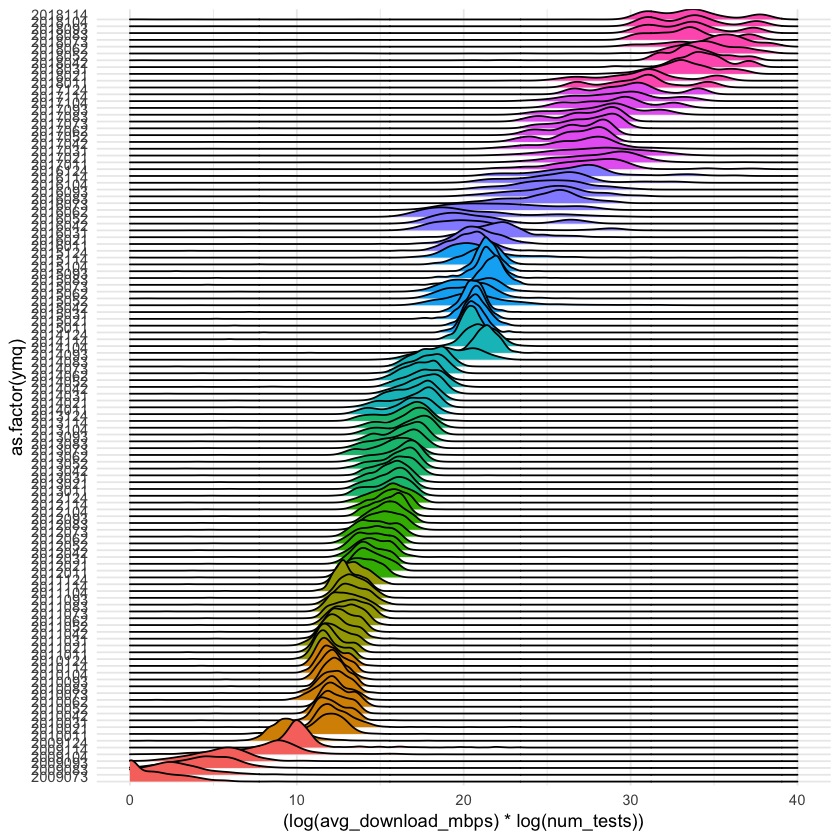

In [7]:
#Create Ridgeline Graphic
#mlabdata6 <- read.csv("~/Dropbox/OTI/MLab/code/mlab-joyplot/ridgeline5.csv")

ggplot(todo_copies, aes(x = (log(avg_download_mbps)*log(num_tests)), y = as.factor(ymq), height=..density.., fill = y)) +
  geom_density_ridges(stat="density",scale=5) +
  theme_minimal(base_size = 11) +
  theme(axis.text.y = element_text(vjust = 0)) +
  theme(legend.position = "none") +
  xlim(0, 40)
